<a href="https://colab.research.google.com/github/tomgoter/w207_finalproject/blob/master/basic_cnn_example_ctw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Keypoint Detection
## Demonstration of a simple Convolutional Neural Network
### Chris Weyandt  -  W207 Final Project - Summer 2019


Built from examples in Tom Goter's github repo 
 - https://github.com/tomgoter/w207_finalproject/blob/master/DataExploration.ipynb
 - https://github.com/tomgoter/w207_finalproject/blob/master/cnn_notebook_tpg.ipynb
 - https://github.com/tomgoter/w207_finalproject/blob/master/neural_net_analysis.ipynb
 - https://github.com/tomgoter/w207_finalproject/blob/master/tf_notebook_tpg.ipynb
 - and a tutorial at https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

## Imports

In [1]:
# Import tensorflow and check the version - we will be using version 1.14
import tensorflow as tf
print(tf.__version__)

# Import needed packages
# from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
# import numpy as np
# import time
from tensorflow.keras import models, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
%matplotlib inline
import os
from google.colab import drive

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, Flatten, Activation
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
#from tensorflow.keras.utils import model_to_dot

1.14.0


In [0]:
# Uncomment the next line to install the livelossplot library on your colab instance
# !pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [0]:
# Clean up your session
tf.keras.backend.clear_session()

## Import our data from our drive
- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb.
- This dataset has the NaNs removed and a few mislabeled images removed as well.
- As such there is only limited training and development data to use.
- The image data has already been normalized to [0,1]

### Choose whether to load files locally or from google drive

In [4]:
# 0 = Local, 1 = Google Drive
drive_source = 1

if drive_source:
  # Mounting the drive is straightforward but required authentication each time 
  # we reset the session
  drive.mount('/content/drive', force_remount=True)
  drive_path = '/content/drive/My Drive/FacialKeypointDetection/'
  ! ls /content/drive/My\ Drive/FacialKeypointDetection/
else:
  drive_path = './'

Mounted at /content/drive
df_nostache_nonan.pkl	      df_nostache.pkl	      Models	  viz
df_nostache_nonan_w_flip.pkl  df_nostache_w_flip.pkl  OutputData


In [5]:
# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle(drive_path + "df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x.reshape(96,96,1) for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])

X.shape

(2140, 96, 96, 1)

## Create a Epoch Timing Callback

In addition to using RMSE as a metric to evaluate our models against, we also want to track model training time. If a factor of 10 increase in training time leads to a small accuracy benefit we will tend to gravitate toward the more efficient model.

In [0]:
# The early stop callback will terminate a training session if no progress is being made
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')

# The plot_losses callback will display a plot of RMSE and Accuracy 
# and auto-update the plot every few epochs during the training session.
plot_losses = PlotLossesCallback()

## Create the basic CNN model

- Nice blog post: https://www.analyticsvidhya.com/blog/2017/06/architecture-of-convolutional-neural-networks-simplified-demystified/
- https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [7]:
# Create a simple sequential cnn model
simple_cnn = Sequential()

# Take in a 96x96 pixel grayscale image
simple_cnn.add(InputLayer(input_shape=(96,96,1), name='Image'))

# Perform convolution with a 3x3 kernel with a depth of six 
simple_cnn.add(Conv2D(6, (3,3), padding='same', activation='relu', name='3x3Kernel'))

# Convert to 1D representation (a simple neural net)
simple_cnn.add(Flatten(name='ToSimpleNet'))

# Convert to feature space representing the 30 keypoint parameters
simple_cnn.add(Dense(30, name='To30Features'))

# Predict outputs
simple_cnn.add(Activation('linear', name='Predict'))

# Plot a diagram of the model
plot_model(simple_cnn, to_file=drive_path + 'viz/simple_cnn_plot.png', show_shapes=True, show_layer_names=True)
simple_cnn.summary()

W0806 00:59:23.211659 140592333715328 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3x3Kernel (Conv2D)           (None, 96, 96, 6)         60        
_________________________________________________________________
ToSimpleNet (Flatten)        (None, 55296)             0         
_________________________________________________________________
To30Features (Dense)         (None, 30)                1658910   
_________________________________________________________________
Predict (Activation)         (None, 30)                0         
Total params: 1,658,970
Trainable params: 1,658,970
Non-trainable params: 0
_________________________________________________________________


In [0]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Train the Model

The following information is useful to know when setting up our model:

**batch_size**
Determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.

**steps_per_epoch**
The number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.

**validation_steps**
similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.

**callback references**
https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

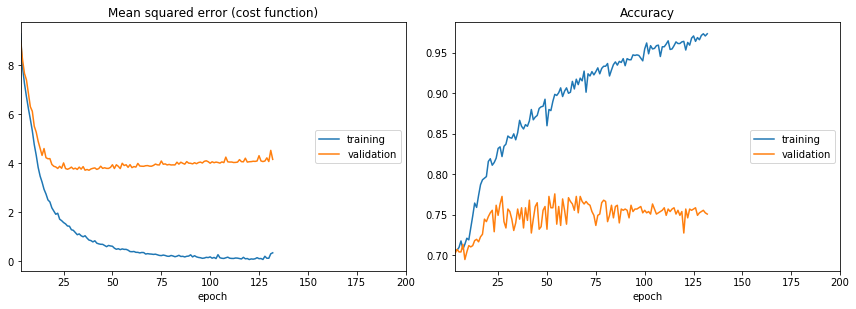

Mean squared error (cost function):
training   (min:    0.069, max:  372.066, cur:    0.343)
validation (min:    3.715, max:  134.921, cur:    4.162)

Accuracy:
training   (min:    0.623, max:    0.973, cur:    0.973)
validation (min:    0.695, max:    0.776, cur:    0.751)


In [8]:
simple_cnn.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mean_squared_error', 
              metrics=['accuracy'])

history = simple_cnn.fit(
    X, y,
    epochs=200,
    batch_size=32,
    validation_split = 0.3,
    callbacks=[plot_losses, early_stop],
    verbose=0)

## Visualizing predictions

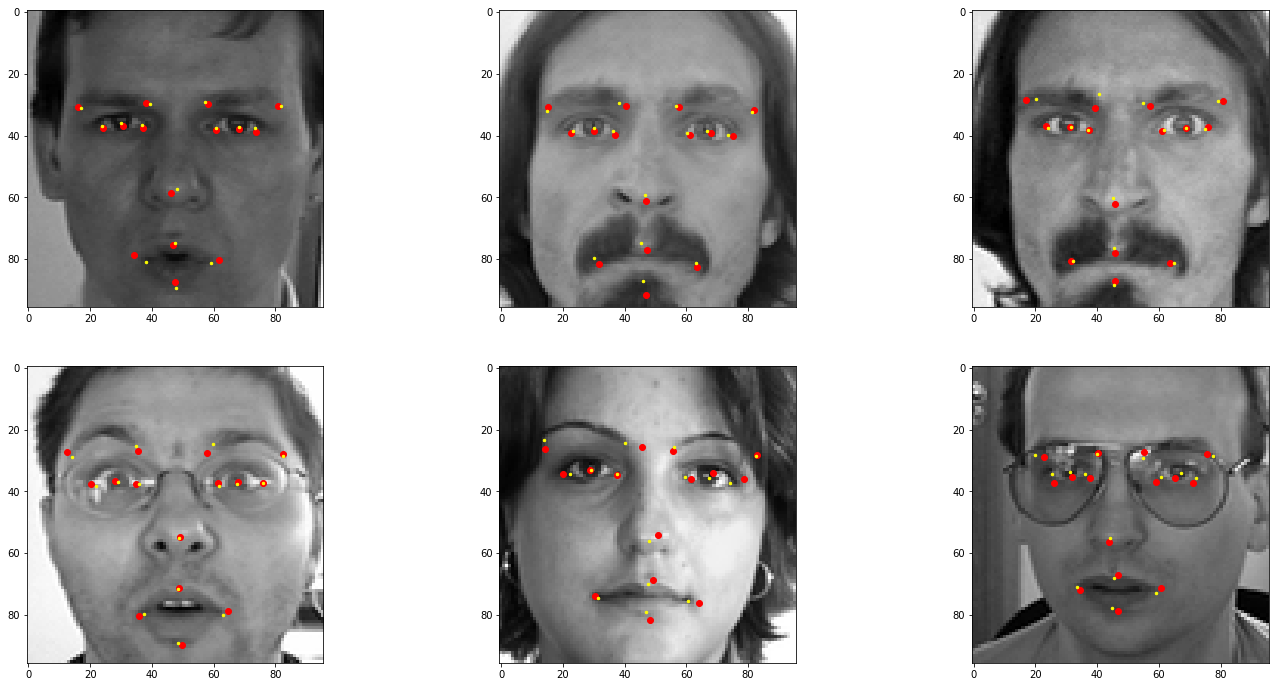

In [39]:
start_img = 2000

predictions = simple_cnn.predict(X[start_img:start_img+24])
actuals = y[start_img:start_img+24]

fig, axes = plt.subplots(2,3, figsize=(24,12))
axes = axes.flatten()
xs = predictions[:,0:30:2]
ys = predictions[:,1:30:2]
x_act = actuals[:,0:30:2]
y_act = actuals[:,1:30:2]
for i, ax in enumerate(axes):
    ax.imshow(np.reshape(X[start_img+i],(96,96)), origin='upper', cmap='gray')
    ax.scatter(x=xs[i,:], y=ys[i,:], color='red')
    ax.scatter(x=x_act[i,:], y=y_act[i,:], color='yellow', s=6)

fig.savefig(drive_path + "/viz/pred_img.png") 

## Visualizing convolution layers

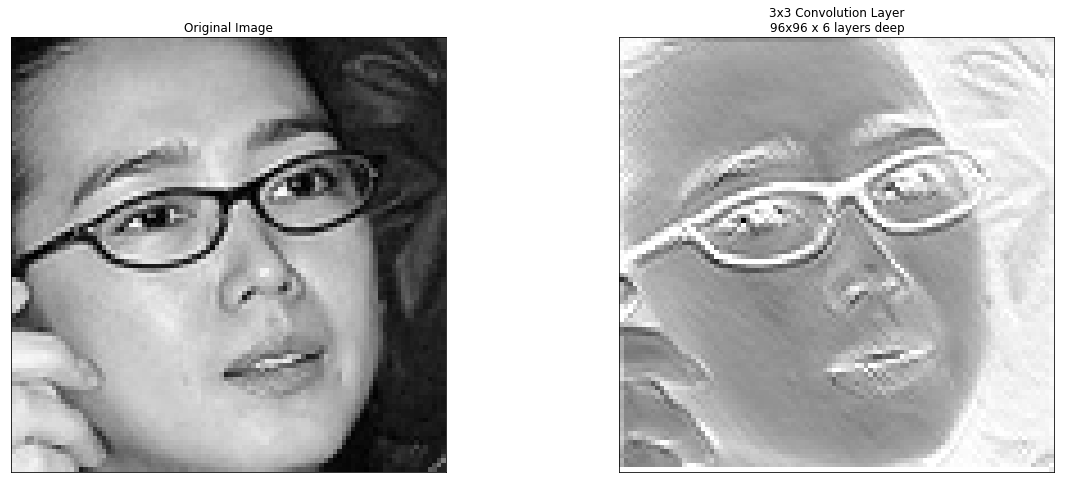

In [21]:
layer_names = ['3x3Kernel']

labels = ['3x3 Convolution Layer\n96x96 x 6 layers deep']

fig, axes = plt.subplots(1, len(layer_names)+1, figsize=(20,8),
                         subplot_kw={'xticks':[],'yticks':[]})

axes = axes.flatten()

axes[0].imshow(X[2011].reshape(96,96),cmap='gray')

for l, layer in enumerate(layer_names):
  intermediate_layer_model = models.Model(inputs=simple_cnn.input,
                                    outputs=simple_cnn.get_layer(name=layer).output)
  intermediate_output = intermediate_layer_model.predict([X[2011].reshape(1,96,96,1)])
  pixels = len(intermediate_output[0,:,:1])
  plot_data = intermediate_output[0,:,:,3].reshape(pixels,pixels)
  axes[l+1].imshow(plot_data,cmap='gray_r')
  axes[l+1].set_title(labels[l])

axes[0].set_title("Original Image")
fig.savefig(drive_path + "/viz/conv_img_1row.png")  


print()